# model 1 

 sara 


#  -------------------------------------------------------------------------------------------

# imports

In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import numpy as np
from keras_tqdm import TQDMNotebookCallback
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import os
import string
from nltk.tokenize import TreebankWordTokenizer
from numpy.random import random_sample
import re
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.layers import Embedding, Flatten,LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation,  Input, merge,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Convolution1D
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.layers import Concatenate, concatenate
from keras import backend as K
from keras.layers import multiply
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.regularizers import l2 
random_seed=1337

Using TensorFlow backend.


###  Define Callback functions to generate Measures

In [3]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Experiments to reproduce the results of Table 9 

### Load pre procssed Data

In [8]:
with open('../data/pickles/train_and_test_data_sentences_snp_2class.pickle', 'rb') as handle:
#with open('../../SNP-Disease/train_and_test_data_sentences_snp_2classWiki.pickle', 'rb') as handle:

    W_train = pickle.load(handle)
    d1_train = pickle.load(handle)
    d2_train = pickle.load(handle)
    Y_train = pickle.load(handle)
    Tr_word_list = pickle.load(handle)
    
    W_test = pickle.load(handle)
    d1_test = pickle.load(handle)
    d2_test = pickle.load(handle)
    Y_test = pickle.load(handle)
    Te_word_list = pickle.load(handle)
    
    
    word_vectors = pickle.load(handle)
    word_dict = pickle.load(handle)
    d1_dict = pickle.load(handle)
    d2_dict = pickle.load(handle)
    label_dict = pickle.load(handle)
    MAX_SEQUENCE_LENGTH = pickle.load(handle)
    
    
    

### Prepare Word Embedding Layer

In [11]:
EMBEDDING_DIM=word_vectors.shape[1]
embedding_matrix=word_vectors

def create_embedding_layer(l2_reg=0.1,use_pretrained=True,is_trainable=False):
    
    if use_pretrained:        
        return Embedding(len(word_dict) ,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=is_trainable,embeddings_regularizer=regularizers.l2(l2_reg))
    else:    
        return Embedding(len(word_dict) ,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
            

In [13]:
INPUT_DIM = 2
TIME_STEPS = MAX_SEQUENCE_LENGTH

In [15]:
def attentionNew(inputs):
    inputs = Lambda(lambda x: tf.keras.backend.sigmoid(x))(inputs)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a_probs])
    output_attention_mul = Lambda(lambda x: tf.keras.backend.sigmoid(x))(output_attention_mul)
    return output_attention_mul


### Create the Model

In [17]:
from keras.optimizers import Adam
def build_model():    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = create_embedding_layer(use_pretrained=True, is_trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    # First Conv1D Layer
    x = Conv1D(256, 7, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.4)(x)

    # Second Conv1D Layer
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.4)(x)
    
    conv_sequence = GlobalMaxPooling1D()(x)  # GlobalMaxPooling after all CNN layers

    # Bidirectional RNN layers
    forward = LSTM(100, return_sequences=True, recurrent_dropout=0.05)(embedded_sequences)
    backward = LSTM(100, return_sequences=True, go_backwards=True, recurrent_dropout=0.05)(embedded_sequences)
    lstm_gru_sequence = concatenate([forward, backward], axis=-1)

    # Apply attention mechanism
    attention_output = attentionNew(lstm_gru_sequence)
    attention_pooled = GlobalMaxPooling1D()(attention_output)

    # Merge CNN and attention-enhanced RNN outputs
    merge = concatenate([conv_sequence, attention_pooled])

    # Fully connected layers
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merge)
    x = Dropout(0.4)(x)
    preds = Dense(2, activation='softmax')(x)

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', f1])
    
    return model


In [19]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 91)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 91, 200)      555000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 91, 100)      120400      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 91, 100)      120400      embedding_1[0][0]                
____________________________________________________________________________________________

### Run the Evaluation on the test dataset 

In [9]:
param='macro'
epochs =70
batch_size = 32
history=model.fit(W_train, Y_train,epochs=epochs,validation_data=(W_test,Y_test), batch_size=batch_size,verbose=1)        



Train on 935 samples, validate on 365 samples
Epoch 1/70
935/935 [==============================] - 2s 3ms/step - loss: 5023.6647 - acc: 0.7059 - f1: 0.6949 - val_loss: 5023.1115 - val_acc: 0.7068 - val_f1: 0.6909
Epoch 2/70
935/935 [==============================] - 3s 3ms/step - loss: 5022.6282 - acc: 0.7176 - f1: 0.7213 - val_loss: 5022.1397 - val_acc: 0.7068 - val_f1: 0.6909
Epoch 3/70
935/935 [==============================] - 3s 3ms/step - loss: 5021.6634 - acc: 0.7433 - f1: 0.7500 - val_loss: 5021.2463 - val_acc: 0.7068 - val_f1: 0.6909
Epoch 4/70
935/935 [==============================] - 3s 3ms/step - loss: 5020.7641 - acc: 0.7487 - f1: 0.7515 - val_loss: 5020.3706 - val_acc: 0.7068 - val_f1: 0.6909
Epoch 5/70
935/935 [==============================] - 3s 3ms/step - loss: 5019.9258 - acc: 0.7561 - f1: 0.7588 - val_loss: 5019.5534 - val_acc: 0.7068 - val_f1: 0.6909
Epoch 6/70
935/935 [==============================] - 3s 3ms/step - loss: 5019.1490 - acc: 0.7540 - f1: 0.7455 - v

935/935 [==============================] - 3s 3ms/step - loss: 5009.4017 - acc: 0.9872 - f1: 0.9875 - val_loss: 5009.6236 - val_acc: 0.9041 - val_f1: 0.8974
Epoch 50/70
935/935 [==============================] - 3s 3ms/step - loss: 5009.3891 - acc: 0.9754 - f1: 0.9723 - val_loss: 5009.5770 - val_acc: 0.9014 - val_f1: 0.8948
Epoch 51/70
935/935 [==============================] - 3s 3ms/step - loss: 5009.3583 - acc: 0.9882 - f1: 0.9885 - val_loss: 5009.5156 - val_acc: 0.9123 - val_f1: 0.9129
Epoch 52/70
935/935 [==============================] - 3s 3ms/step - loss: 5009.3444 - acc: 0.9882 - f1: 0.9885 - val_loss: 5009.4783 - val_acc: 0.9068 - val_f1: 0.9038
Epoch 53/70
935/935 [==============================] - 3s 3ms/step - loss: 5009.3203 - acc: 0.9872 - f1: 0.9875 - val_loss: 5009.5036 - val_acc: 0.9068 - val_f1: 0.8962
Epoch 54/70
935/935 [==============================] - 3s 3ms/step - loss: 5009.3042 - acc: 0.9925 - f1: 0.9927 - val_loss: 5009.4501 - val_acc: 0.9123 - val_f1: 0.912

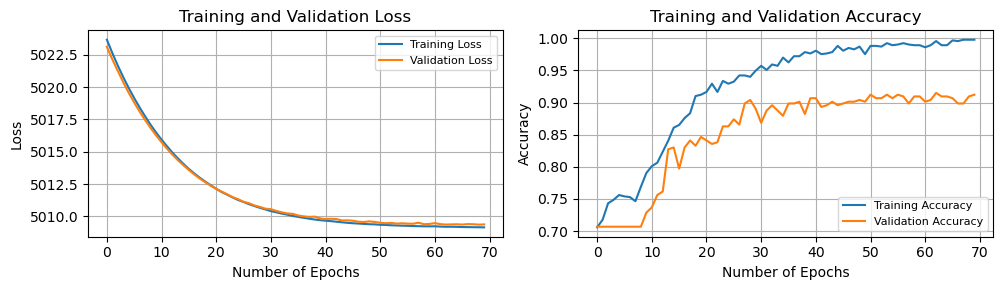

In [13]:
import matplotlib.pyplot as plt

# Training & Validation accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = len(train_loss)

xc = range(epochs)

plt.figure(figsize=(10, 3))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(xc, train_loss, label='Training Loss')
plt.plot(xc, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training and Validation Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(xc, train_acc, label='Training Accuracy')
plt.plot(xc, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=12)
plt.legend(fontsize=8, loc='lower right')  # Change position to lower right
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
predicted = np.argmax(model.predict(W_test), axis=1)
y_test_to_label= np.argmax(Y_test, axis=1)
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)


# Generate the classification report as a dictionary
report_dict = classification_report(y_test_to_label, predicted, output_dict=True)

# Create a new dictionary to hold the formatted values
formatted_report_dict = {}

# Iterate over the items in the report dictionary
for key, value in report_dict.items():
    if isinstance(value, dict):
        # Format the nested dictionary values
        formatted_report_dict[key] = {sub_key: f"{sub_value:.4f}" for sub_key, sub_value in value.items()}
    else:
        # Format the top-level dictionary values
        formatted_report_dict[key] = f"{value:.4f}"

# Create a string representation of the formatted dictionary
formatted_report_str = classification_report(y_test_to_label, predicted, digits=4)

# Print the formatted classification report
print(formatted_report_str)


print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))

              precision    recall  f1-score   support

           0     0.9412    0.7477    0.8333       107
           1     0.9036    0.9806    0.9405       258

    accuracy                         0.9123       365
   macro avg     0.9224    0.8641    0.8869       365
weighted avg     0.9146    0.9123    0.9091       365

 Precision:92.24% Recall:86.41% Fscore:88.69% 


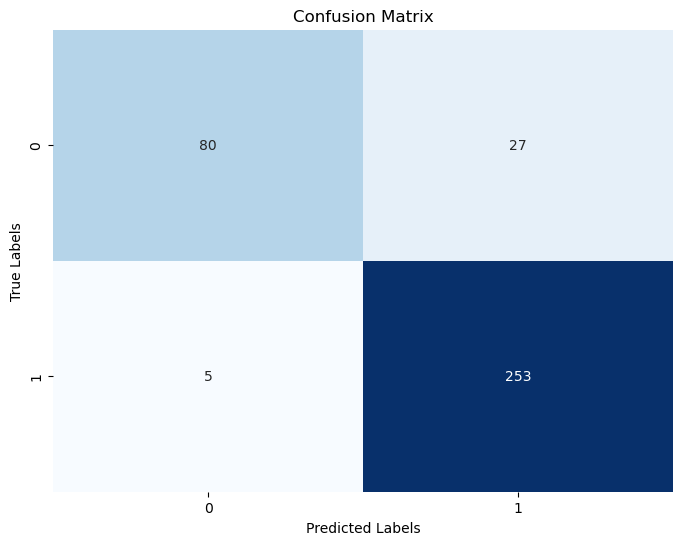

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels
predicted_labels = np.argmax(model.predict(W_test), axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()